In [1]:
# 1) IMPORT PACKAGES

import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import seaborn as sns
import folium

from datetime import date
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from distutils.command import sdist
from folium import plugins
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

os.environ['USE_PYGEOS'] = '0'


In [127]:
# 2) NOTEBOOK FUNCTIONS

# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """
    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000,
    )

    #found_items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items())  # for pystac-client < 0.4.0

    # Need this to get the url path for downloading the files to local machine.
    itemjson = search.item_collection_as_dict() 

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '.061_'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse()  # make the results ascending in time

    num_tiles = len(found_items)
    print("Colllection: {}.  {} Images found.".format(collection, num_tiles))

    return (found_items, num_tiles, itemjson)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(asset, items, num_tiles, poly_gdf):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')
    
    # # Create polygon Area of Interest (AOI for which to sample.).
    # clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)

    #clipped = FH_StackedDataset(ds.rio.clip(poly_gdf.geometry))
    clipped = FH_StackedDataset(ds.rio.clip(poly_gdf.geometry, all_touched=True, drop=True))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds)

# ------------------------------------------------------------------------------

def read_ameriflux(data_path):

    print('Reading file {}'.format(data_path))

    df = pd.read_csv(data_path, header=0, na_values=[-9999.000000])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M.0")
    )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] + timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] + timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END']
                 + value_cols.to_list())
    df = df[col_order]

    return df

# ---------------------------------------------------------------------------------

In [3]:
# 3) STAC LOGIN

# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination
# and use it to authorize access to the STAC API given by the `cat_url`
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization': 'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

if not catalog.id == 'stac-server':
    print("You have failed to log into the STAC server\n")
else:
    print("You are succesfully logged in to the STAC server and you can now begin STAC queries.\n")


You are succesfully logged in to the STAC server and you can now begin STAC queries.



In [136]:
# 4) ANALYSIS SETUP.  AOI CLIPPING POLYGON CREATED.

# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Set dates for two growing seasons.  Each growing season will
# be plotted seperately.
#start1 = '2021-05-01T00:00:00Z'
#end1 = '2021-10-31T00:00:00Z'
#
#start2 = '2022-05-01T00:00:00Z'
#end2 = '2022-10-31T00:00:00Z'

start1 = '2022-06-01'
end1 = '2022-09-30'

#start2 = '2022-06-01'
#end2 = '2022-09-30'

# Insitu point locations
insitu_met_points = {
    'Corn': [38.1094, -121.5361],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Corn': [-121.536114, 38.109538],
    'Corn2': [-121.533, 38.10607],
    'Alfalfa': [-121.5015, 38.0994],
    'Ames': [-93.701, 42.000],
}

aoi_coordinates = {
    'Alfalfa': [
        (-121.504670, 38.100631),
        (-121.501246, 38.101757),
        (-121.498513, 38.098168),
        (-121.501920, 38.097003)
    ],
    'Corn': [
        (-121.5352703314288,38.11067012116794),
        (-121.537017491703,38.1103395663037),
        (-121.5370233431901,38.10841814871685),
        (-121.5352318761426,38.10893740470007),
        (-121.5352703314288,38.11067012116794),
   ],
    'Corn2': [
    (-121.5344444486311,38.10287555732225),
    (-121.5314483994475,38.10375752472796),
    (-121.5315333645822,38.10922251872468),
    (-121.5344774233088,38.10830220203034),
    (-121.5344444486311,38.10287555732225),
    ],
    
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to met data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':

    bbox = [-121.5027, 38.0986, -121.5003, 38.1000]
    met_path = os.path.join(data_path,
                            'US-Bi1_HH_201608130000_202301010000.csv')
    aoi = aoi_coordinates['Alfalfa']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))

elif analysis == 'Corn':

    bbox = [-121.5352703314288,38.11067012116794,-121.5352318761426,38.10893740470007]
    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))
        
elif analysis == 'Corn2':

    bbox = [-121.5352703314288,38.11067012116794,-121.5352318761426,38.10893740470007]
    met_path = os.path.join(data_path,
                            'US-Bi2_HH_201704270000_202301010000.csv')
    
    aoi = aoi_coordinates['Corn']
    poly = Polygon(aoi)
    poly_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs=CRS.from_epsg(4326))
    poly_gdf = poly_gdf.to_crs(crs=CRS.from_epsg(32610))

    if not os.path.exists(data_path):
        print("You do not have the required Ameriflux data file for a {} analysis".format(
            analysis))


# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]}

print("Analysis setup comlete.\n")

Analysis setup comlete.



In [ ]:
# 5) FOLIUM MAP OF AOI.

# Use WGS 84 (epsg:4326) as the geographic coordinate system
# df1 = gpd.GeoDataFrame(modis_500m_aoi_df.to_crs(epsg=4326))
#modis_500m_df = gpd.GeoDataFrame(aoi_list[0].to_crs(epsg=4326))
#modis_250m_df = gpd.GeoDataFrame(aoi_list[2].to_crs(epsg=4326))
#lsat_65m_df = gpd.GeoDataFrame(aoi_list[1].to_crs(epsg=4326))

p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])

m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=15,
               tiles='CartoDB positron', control_scale=True)

# ---------------------------------
# Use satellite image for base map.
tile = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)
# ---------------------------------

# add the polygon and centroid
df = poly_gdf.to_crs(epsg=4326)

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)
m

In [133]:
# 6) SENTINEL & MODIS IMAGE SEARCH

collections = ["prepped_inputs_s2"]

# Search STAC for available images.
(s2_items, num_s2_tiles, itemjson) = stac_tile_search("prepped_inputs_s2", geom, start1, end1)
(mcd43a4_items, num_mcd43a4_tiles, itemjson) = stac_tile_search("prepped_inputs_mcd43a4", geom, start1, end1)

# Print out the first and last dates of the found items (images).
print(f"First S2 date: {s2_items[0]}")
print(f"Last S2 date: {s2_items[-1]}")

print(f"First MCD date: {mcd43a4_items[0]}")
print(f"Last MCD date: {mcd43a4_items[-1]}")

Colllection: prepped_inputs_s2.  25 Images found.
Colllection: prepped_inputs_mcd43a4.  36 Images found.
First S2 date: <Item id=S2_10SFH_median_composite_20220606>
Last S2 date: <Item id=S2_10SFH_median_composite_20220924>
First MCD date: <Item id=MCD43A4.061_20220822_10SFH>
Last MCD date: <Item id=MCD43A4.061_20220930_10SFH>


In [134]:
# 7) EXTRACT SENTINEL2 & MODIS SURFACE REFLECTANCE & COMPUTE NDVI

# Sentinel 2 --------------------------------------------------------

# Get images from stack.
(aoi_stack_ds) = create_aoi_image_stack(
    'surface_reflectance', s2_items, num_s2_tiles, poly_gdf)

# Pull out NIR and Red bands.
red_aoi_ds = aoi_stack_ds.isel(band=2)
nir_aoi_ds = aoi_stack_ds.isel(band=6)

# Compute NDVI.
ndvi_aoi_ds = (nir_aoi_ds - red_aoi_ds) / (nir_aoi_ds + red_aoi_ds)

# Modis --------------------------------------------------------------

# Get images from stack
(aoi_stack_ds) = create_aoi_image_stack(
    'surface_reflectance', mcd43a4_items, num_mcd43a4_tiles, poly_gdf)

# Pull out NIR and Red bands.
red_aoi_mcd_ds = aoi_stack_ds.isel(band=0)
nir_aoi_mcd_ds = aoi_stack_ds.isel(band=1)

# Compute NDVI.
ndvi_aoi_mcd_ds = (nir_aoi_mcd_ds - red_aoi_mcd_ds) / (nir_aoi_mcd_ds + red_aoi_mcd_ds)

# Create a NDVI AOI mean dataset.
# mean_ndvi_aoi_ds = ndvi_aoi_ds.mean(dim=["x", "y"])
# mean_df = mean_ndvi_aoi_ds.to_dataframe(name='s2_mean_ndvi')
# Create a NDVI AOI variance dataset.
#var_ndvi_aoi_ds = ndvi_aoi_ds.var(dim=["x", "y"])

# Convert dataasets to dataframes.
# * this takes over an hour to process *
# s2_ndvi_df = ndvi_aoi_ds.to_dataframe(name='s2_ndvi')

/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


In [ ]:
# 8) PLOT SENTINEL 2 IMAGES OF NDVI MEAN & VARIANCE

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))

# Convert our slice time endpoints to compatabile format.
d1 = pd.to_datetime('2022-07-01', utc=True)
d2 = pd.to_datetime('2022-07-31', utc=True)

# Select slices, compute stats, and plot.
# Mean and Variance.
a = ndvi_aoi_ds.sel(time=slice(d1,d2)).mean(dim='time').plot(ax=ax1)
b = ndvi_aoi_ds.sel(time=slice(d1,d2)).var(dim='time').plot(ax=ax2)

# Adjust plot elements.

ax1.set_title('Mean of Sentinel 2 NDVI')
ax2.set_title('Variance of Sentinel 2 NDVI')
fig.suptitle('Sentinel 2 NDVI July 1-31, 2022')

ax1.set_yticklabels('')
ax2.set_yticklabels('')

ax1.set_xticklabels('')
ax2.set_xticklabels('')

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')

plt.tight_layout()

In [135]:
# 9) CONVERT SENTINEL 2 and MODIS TO DATAFRAME & RESAMPLE.

# Resampling simplifies the timestamp in that it removes the hours and minutes 
# and makes each day's dt consistent.  In addition, resampling fills in missing dates 
# with NA which will help with plotting consistency.

# Sentinel 2 ------------------------------------------------------
# Convert dataaset to a dataframe.
s2_ndvi_df = ndvi_aoi_ds[0:24,:,:].to_dataframe(name='s2_ndvi')
# Drop uneeded columns.
s2_ndvi_df.drop(columns=['spatial_ref'], inplace=True)
# Convert multilevel index to single level.
s2_ndvi_df = s2_ndvi_df.reset_index(level=[1, 2])
# Put index into dt64 format.
s2_ndvi_df.index = pd.to_datetime(s2_ndvi_df.index)
# Resample to just the y-m-d and take the mean() which in this case
# will be the mean ndvi for the AOI.
s2_ndvi_resampled_df = s2_ndvi_df.groupby(['x','y']).resample('D', origin=pd.to_datetime(start1, utc=s2_ndvi_df.index.tz)).mean()
# s2_ndvi_mean_df = s2_ndvi_df.resample('D').mean()  # NExt cell instead.
# Drop uneeded cols and make a single index instead of multi.
s2_ndvi_resampled_df.drop(columns=['y','x'], inplace=True)
s2_ndvi_resampled_df = s2_ndvi_resampled_df.reset_index(level=[0, 1])
# Resort so that rows are chronologically grouped.
s2_ndvi_resampled_sort_df = s2_ndvi_resampled_df.sort_index()

# Modis --------------------------------------------------------
# Convert dataaset to a dataframe.
mcd_ndvi_df = ndvi_aoi_mcd_ds[0:24,:,:].to_dataframe(name='mcd_ndvi')
# Drop uneeded columns.
mcd_ndvi_df.drop(columns=['spatial_ref'], inplace=True)
# Convert multilevel index to single level.
mcd_ndvi_df = mcd_ndvi_df.reset_index(level=[1, 2])
# Put index into dt64 format.
mcd_ndvi_df.index = pd.to_datetime(mcd_ndvi_df.index)
# Resample to just the y-m-d and take the mean() which in this case
# will be the mean ndvi for the AOI.
mcd_ndvi_resampled_df = mcd_ndvi_df.groupby(['x','y']).resample('D', origin=pd.to_datetime(start1, utc=mcd_ndvi_df.index.tz)).mean()
# s2_ndvi_mean_df = s2_ndvi_df.resample('D').mean()  # NExt cell instead.
# Drop uneeded cols and make a single index instead of multi.
mcd_ndvi_resampled_df.drop(columns=['y','x'], inplace=True)
mcd_ndvi_resampled_df = mcd_ndvi_resampled_df.reset_index(level=[0, 1])
# Resort so that rows are chronologically grouped.
mcd_ndvi_resampled_sort_df = mcd_ndvi_resampled_df.sort_index()

In [137]:
# 10) CREATE DATAFRAMES OF MEAN SENTINEL 2 and MODIS NDVI.

s2_ndvi_mean_df = s2_ndvi_resampled_df.groupby(['time']).resample('D').mean()
mcd_ndvi_mean_df = mcd_ndvi_resampled_df.groupby(['time']).resample('D').mean()

#s2_ndvi_max_df = s2_ndvi_resampled_df.groupby(['time']).resample('D').max()
#s2_ndvi_min_df = s2_ndvi_resampled_df.groupby(['time']).resample('D').min()

s2_ndvi_mean_df.rename(columns={"s2_ndvi": "s2_mean_ndvi"}, inplace=True)
mcd_ndvi_mean_df.rename(columns={"mcd_ndvi": "mcd_mean_ndvi"}, inplace=True)
#s2_ndvi_max_df.rename(columns={"s2_ndvi": "s2_max_ndvi"}, inplace=True)
#s2_ndvi_min_df.rename(columns={"s2_ndvi": "s2_min_ndvi"}, inplace=True)

s2_ndvi_mean_df = s2_ndvi_mean_df.reset_index(level=[1])
mcd_ndvi_mean_df = mcd_ndvi_mean_df.reset_index(level=[1])

#s2_ndvi_max_df = s2_ndvi_max_df.reset_index(level=[1])
#s2_ndvi_min_df = s2_ndvi_min_df.reset_index(level=[1])


In [ ]:
# 11) BOXPLOT OF SENTINEL2 NDVI AOI PIXELS.

from numpy import dtype

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Make box plots.
box = (
    sns.boxplot(
    #x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')),
    x=s2_ndvi_resampled_df.index.strftime('%Y-%m-%d'),
    y=s2_ndvi_resampled_df['s2_ndvi'],
    ax=ax1)
    .set(title="Sentinel 2 NDVI (June - September 2022)"),
    )
""" 
box = (
    sns.boxplot(
    #x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')),
    x=mcd_ndvi_resampled_df.index.strftime('%Y-%m-%d'),
    y=mcd_ndvi_resampled_df['mcd_ndvi'],
    ax=ax2)
    .set(title="Modis NDVI (June - September 2022)"),
    )
"""
#box = (
#    sns.boxplot(
#    # x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')),
#    x=s2_ndvi_resampled_sort_df[start1:end1].index.strftime('%Y-%m-%d'),
#    y=s2_ndvi_resampled_sort_df[start1:end1]['s2_ndvi'],
#    ax=ax1)
#    .set(title="Sentinel 2 NDVI : AOI: 130 m2"),
#    )

#box = (
#    sns.boxplot(
#    # x=s2_ndvi_df.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d')),
#    x=s2_ndvi_resampled_df[start2:end2].index.strftime('%Y-%m-%d'),
#    y=s2_ndvi_resampled_df[start2:end2]['s2_ndvi'],
#    ax=ax2)
#    .set(title="Sentinel 2 NDVI : AOI: 130 m2"),
#    )

#ax1.plot(resampled_df['2021-05-01':'2021-10-31'].index.strftime('%Y-%m-%d'), resampled_df['2021-05-01':'2021-10-31']['s2_ndvi'])

ax1.set_ylabel('Sentinel 2 NDVI')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax1.tick_params(labelrotation=25)

""" 
ax2.set_ylabel('Modis NDVI')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax2.tick_params(labelrotation=25)
"""
ax1.grid()
#ax2.grid()

plt.tight_layout()

In [141]:
# 12) GET METEOROLOGY INTO DATAFRAME FOR CATD CALCS.

# Will use met_df in next code cell.
met_df = read_ameriflux(met_path)

Reading file ../data/Ameriflux/US-Bi2_HH_201704270000_202301010000.csv


In [142]:
# 13) EXTRACT LST.  COMPUTE CATD.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting

# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.

# prepped_inputs_landsat = resampled to 30 m
# prepped_inputs_mod21a1d = 1000 m
# pydms_sharpened_modis = 500 m
# pydms_sharpened_landsat = downscaled to 20 m
# starfm_predictions_modis_landsat = 20 m

# ---------------------------------------------------------------------------
# USER EDITS POSSIBLE -------------------------------------------------------
# ---------------------------------------------------------------------------

asset_dict = {
    "prepped_inputs_mod21a1d": ['mod21a1d_lst', 2000, 1000, 'brown'],
    "pydms_sharpened_modis": ['pydms_modis_lst', 1000, 500, 'green'],
    "prepped_inputs_landsat": ['lsat_lst', 60, 30, 'black'],
    "pydms_sharpened_landsat": ['pydms_lsat_lst', 40, 20, 'blue'],
    "starfm_predictions_modis_landsat": ['starfm_lst', 40, 20, 'red'],
}
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

catd_list = [] # A list that will hold single timestep da's of catd.
lst_da_list = []  # A list holding each collections LST dat.
catd_da_list = []  #  Alist holding each collections catd dat.

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    # Just to make sure these lists get reset after each loop iteration.
    found_items1 = []
    found_items2 = []
    found_items = []

    # Search and retrieve images from the two seasons.
    #(found_items1, num_tiles1, itemjson) = stac_tile_search(asset, geom, start1, end1)
    (found_items, num_tiles, itemjson) = stac_tile_search(asset, geom, start1, end1)
    #found_items = found_items1  + found_items2
    #num_tiles = num_tiles1 + num_tiles2
    
    # Extract LST data from AOI. ----------------
    (aoi_lst_da) = create_aoi_image_stack(
            'lst', found_items, num_tiles, poly_gdf)

    # Want to process each timesteps CATD so we iterate through
    # time and work with a single dimension at at time.
    for date, aoi in aoi_lst_da.groupby('time'):

        # Get TA from dataframe using each time step (date).
        ta = met_df.TA.iloc[met_df.index.get_indexer([date], method='nearest')]
        # Convert from C to K.
        ta = ta + 273.15
        # Compute CATD.  Subtract the TA value from each AOI pixel.
        catd = aoi - ta.values
        # Append new CATD da to a list.
        catd_list.append(catd)

    # After each date has been computed.  Concatenate them all together.
    catd_ds = xr.concat(catd_list, coords='minimal', dim='time', compat='override').squeeze()
    # Done with the current CATD list so reset for next asset.
    catd_list = []
    
    catd_da_list.append(catd_ds)
    lst_da_list.append(aoi_lst_da.squeeze())

Colllection: prepped_inputs_mod21a1d.  122 Images found.


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


Colllection: pydms_sharpened_modis.  158 Images found.


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


Colllection: prepped_inputs_landsat.  30 Images found.


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


Colllection: pydms_sharpened_landsat.  30 Images found.


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


Colllection: starfm_predictions_modis_landsat.  92 Images found.


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/exploratory/FH_Hydrosat.py:396: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  datetimes2 = pd.to_datetime(self.datetime, infer_datetime_format=True, utc=True) #more general conversion


In [ ]:
# 14) PLOT IMAGES OF CATD MEAN & VARIANCE

fig, (ax2, ax3, ax4, ax5) = plt.subplots(1,4, figsize=(9,3))

# Convert our slice time endpoints to compatabile format.
#d1 = pd.to_datetime('2022-07-01', utc=True)
#d2 = pd.to_datetime('2022-07-31', utc=True)
#d1 = '2022-07-01'
#d2 = '2022-07-31'

# Select slices, compute stats, and plot.
# Mean and Variance.

# Noted catd_da_list[0] is 1000m Modis so only once cell is extracted for the AOI.  
# This means there is one less dimension compared to the other assets.  You can 
# view the dimensions by printing out catd_da_list[0] vs catd_da_list[1].
#a = catd_da_list[0][:,:].mean(dim='time').plot(ax=ax1)
b = catd_da_list[1][:,:,:].mean(dim='time').plot(ax=ax2)
c = catd_da_list[2][:,:,:].mean(dim='time').plot(ax=ax3)
d = catd_da_list[3][:,:,:].mean(dim='time').plot(ax=ax4)
e = catd_da_list[4][:,:,:].mean(dim='time').plot(ax=ax5)

# Adjust plot elements.
#ax1.set_title('Mean of Prepped Modis')
ax2.set_title('Sharpened Modis')
ax3.set_title('Prepped Landsat')
ax4.set_title('Sharpened Landsat')
ax5.set_title('Fused Landsat & Modis')

fig.suptitle('Mean CATD (June - September 2022)')

ax2.title.set_size(10)
ax3.title.set_size(10)
ax4.title.set_size(10)
ax5.title.set_size(10)

#ax1.set_yticklabels('')
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax4.set_yticklabels('')
ax5.set_yticklabels('')

#ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels('')

#ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')

#ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
""" 
ax2.set_ylim(5,15)
ax3.set_ylim(5,15)
ax4.set_ylim(5,15)
ax5.set_ylim(5,15)
"""

plt.tight_layout()

In [ ]:
# 15) CONVERT CATD DATAARRAYS INTO DATAFRAMES FOR BOXPLOTS.

# Lists to hold datframes for each asset
lst_df_list = []
catd_df_list = []
i=0

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    print (asset)

    # Name the columns to hold catd.
    catd_col_name = "{}_catd".format(asset)
    catd_df = catd_da_list[i].to_dataframe(name=catd_col_name)
    
    # Get rid of unneeded columns.
    # The first asset (i=0), modis @ 1000m only has two levels vs. the 
    # three levels in all the other assets due to the fact that in 
    # the 1000m modis there are only two cells in the y dimension.
    if i == 0:
        catd_df.reset_index(level=[1], inplace=True)
    else:
        catd_df.reset_index(level=[1, 2], inplace=True)

    # Resampling fills in dates that dont exist in the data.
    catd_resampled_df = catd_df.groupby(['x','y']).resample('D').mean()
    catd_resampled_df = catd_resampled_df.droplevel([0,1])

    # Re-sort so that rows are chronologically grouped.
    catd_resampled_df.sort_index(inplace=True)

    # Create a list of dataframes.
    catd_df_list.append(catd_resampled_df)

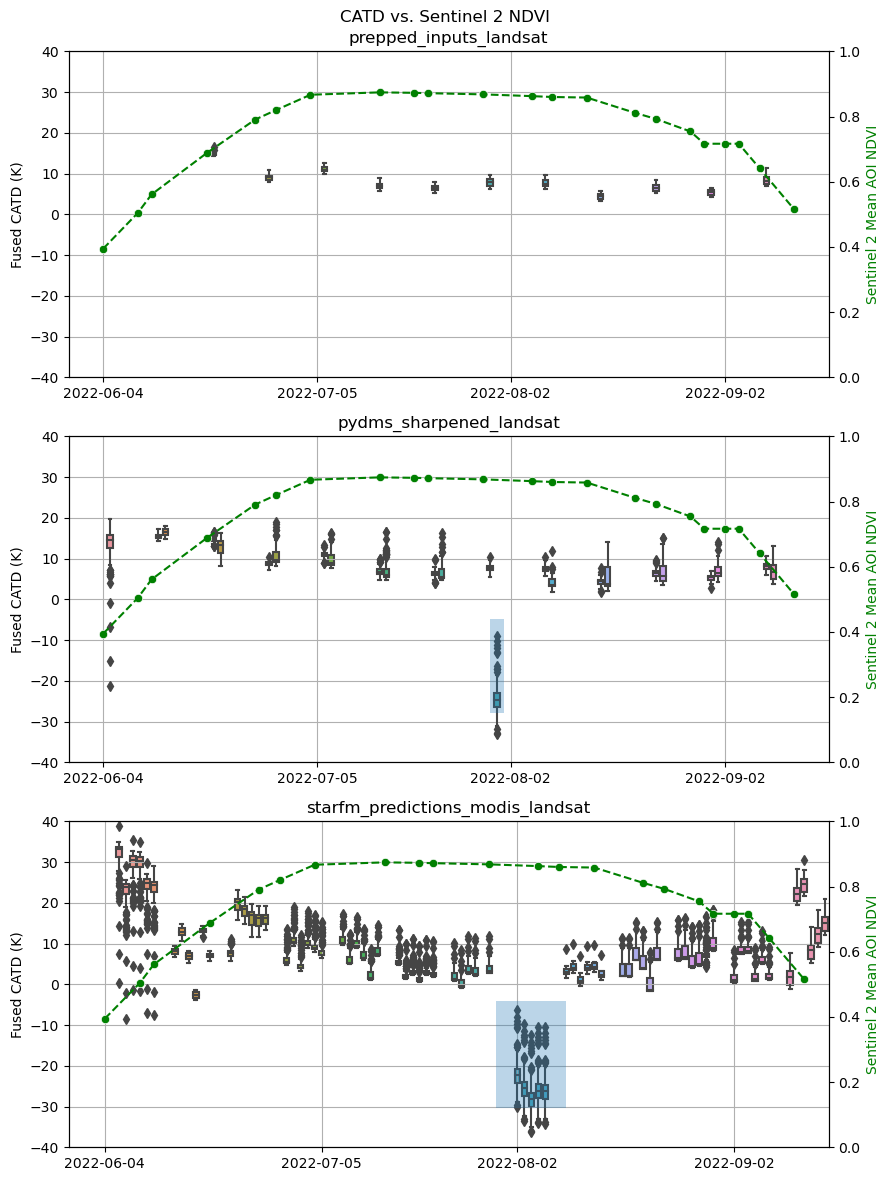

In [282]:
# 16) ANNUAL BOXPLOTS OF CATD

# Create a figure.  Axes will be created in the loop.
fig = plt.figure(figsize=(9, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('CATD vs. Sentinel 2 NDVI')

# Create a counter for getting the number of axes correct.
j = 0

# Loop through each collection in the dictionary.
for i, asset in enumerate(asset_dict):

    # Get the dataframe out of the list but will skip the two MODIS
    # dataframes because there is only mid-august and on data.
    if i <= 1: continue

    df_new_catd = catd_df_list[i]

    # Make box plots. --------------------

    # Create an axes dynamically.  
    ax = plt.subplot(3, 1, j + 1)
    # Increment the axes number up one after each valid dataset.
    j = j + 1
    # Create a twin axes for catd and ndvi.
    twinax0 = ax.twinx()

    # Create a variable for the catd_df column name.  
    catd_col_name = "{}_catd".format(asset)

    # If statements catch any empty dataframes and doesnt try to plot them up.
    if df_new_catd['2022-06-01':'2022-09-15'].size > 0:
    
        # Plot CATD.
        (sns.boxplot(
            x=df_new_catd['2022-06-04':'2022-09-15'].index.strftime('%Y-%m-%d'),
            y=df_new_catd['2022-06-04':'2022-09-15'][catd_col_name],
            ax=ax)
        .set(title="{}".format(asset))
        )
        
        # Plot daily mean NDVI as points.
        (sns.scatterplot(
            x=s2_ndvi_mean_df['2022-06-04':'2022-09-15'].index.astype(str),
            y=s2_ndvi_mean_df['2022-06-04':'2022-09-15']['s2_mean_ndvi'], 
            ax=twinax0, color='green')
        )
        
        # Plot daily mean NDVI as a dashed line in addition to the points.
        (sns.lineplot(
            x=s2_ndvi_mean_df['2022-06-04':'2022-09-15'].index.astype(str),
            y=s2_ndvi_mean_df['2022-06-04':'2022-09-15']['s2_mean_ndvi'], 
            ax=twinax0, color='green', linestyle='dashed')
        )

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.set_ylabel('Fused CATD (K)')
    ax.set_xlabel('')
    twinax0.set_ylabel(ylabel='Sentinel 2 Mean AOI NDVI', color='green')
    ax.set_ylim(-40,40)
    twinax0.set_ylim(0,1)
    ax.grid()

    # Here we want to highlight an area of data on the sharoened landsat (i==3)
    # and the fused (i==4).
    if i == 3:
        plt.axvspan(56, 58, ymin=.15, ymax=.44, alpha=.3)
    if i == 4:
        plt.axvspan(56, 66, ymin=.12, ymax=.45, alpha=.3)

    plt.tight_layout()

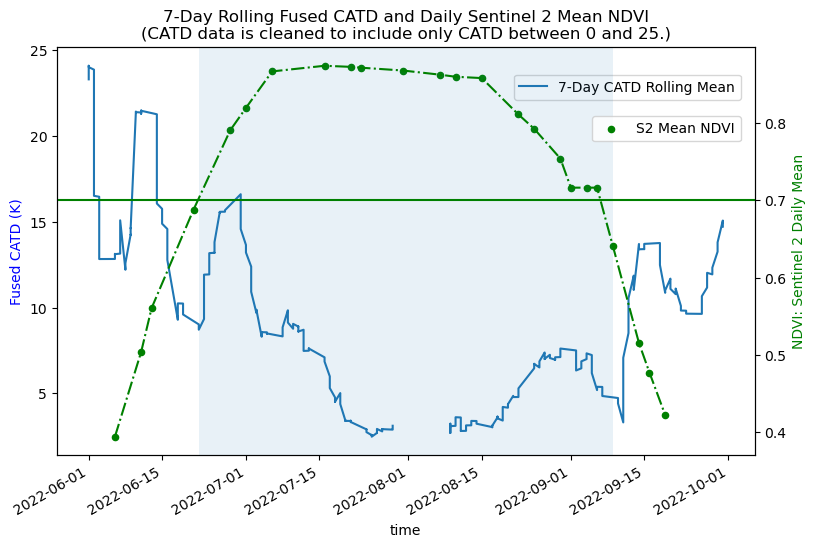

In [267]:
# 17) Rolling CATD vs. NDVI

# Here we take the starfm fused product, clean it of outliers, and run a rolling mean on it.
# We'll do the same with Sentinel NDVI and plot them together.

# Get the dataframe out of the list that we are storing it in.
starfm_df = catd_df_list[4][start1:end1]

# Clean the catd df.  Will take only positive CATD values.  That may not be entirely
# fair, but will do it in this case.
starfm_clean_df = starfm_df[(starfm_df['starfm_predictions_modis_landsat_catd'] >= 0) & (starfm_df['starfm_predictions_modis_landsat_catd'] < 25)]

# Create a dual axis figure.
fig, (ax1) = plt.subplots(1,1,figsize=(9, 6))
ax2 = ax1.twinx()

# Plot rolling median
starfm_clean_df['starfm_predictions_modis_landsat_catd'].rolling(window='7D', min_periods=3).mean().plot(ax=ax1, label='7-Day CATD Rolling Mean')

# Plot NDVI.  First just the points then a dashdot line for visualization.
s2_ndvi_mean_df[start1:end1].plot.scatter(x='time', y='s2_mean_ndvi',color='green', ax=ax2, label='S2 Mean NDVI')
(sns.lineplot(
            x=s2_ndvi_mean_df[start1:end1].index,
            y=s2_ndvi_mean_df[start1:end1]['s2_mean_ndvi'], 
            ax=ax2, color='green', linestyle='dashdot')
)

# Hard code in vertical shading denoting the .7 NDVI "full vegetation" point.
plt.axvspan('2022-06-22', '2022-09-09', alpha=.1)
# Add line reflecting an ndvi of .7 which we assume is near a fully vegetated state.
ax2.axhline(y=.7, color='green')

plt.title('7-Day Rolling Fused CATD and Daily Sentinel 2 Mean NDVI\n(CATD data is cleaned to include only CATD between 0 and 25.)')

ax1.set_ylabel('CATD (K)', color='blue')
ax2.set_ylabel('NDVI: Sentinel 2 Daily Mean', color='green')

ax1.legend(loc='upper right', bbox_to_anchor=(.99, 0.95))
ax2.legend(loc='center right', bbox_to_anchor=(.99, .8))



Next I do some meteorology exploration.  I'm using NDVI from several iterations ago.

In [ ]:
# 18) GET HRRR 2-M AIR TEMPERATURE

# Need number of days of met we want.  Get full range first.
l1 = len(pd.date_range(start='2022-05-01', end='2022-10-31'))
# Use dictinary to get lat, lon.
hrrr_ta_ds1 = get_hrrr_point_data(insitu_met_points['Corn'][0], insitu_met_points['Corn'][1], '2022-05-01', l1)
# Convert series to dataframe.
hrrr_ta = hrrr_ta_ds1.to_dataframe()
hrrr_ta.set_index(pd.to_datetime(hrrr_ta.valid_time.values).strftime('%Y-%m-%d'), inplace=True)
#hrrr_ta = hrrr_ta.index.tz_localize('UTC')

In [ ]:
# 19) SOIL MOISTURE AND NDVI PLOT

fig, (ax, ax3) = plt.subplots(1,2,figsize=(14, 6))
ax2 = ax.twinx()

# We wonly want met for the dt of S2 satellite acquistion time.
match_timestamp = "18:30:00"
met_hr_df = met_df.loc[met_df.index.strftime("%H:%M:%S") == match_timestamp]

ta_df = met_hr_df['2021-05-01':'2022-09-30']['TA']
vpd_df = met_hr_df['2021-05-01':'2022-09-30']['VPD']
precip_df = met_hr_df['2021-05-01':'2022-09-30']['P']
swc16_df = met_hr_df['2021-05-01':'2022-09-30']['Soil water content of sensor 1 at 16cm']
swc26_df = met_hr_df['2021-05-01':'2022-09-30']['Soil water content of sensor 2 at 26cm']

# First Plot.
swc16_df.plot(ax=ax, label='Soil Water @ 16 cm (%)')
swc26_df.plot(ax=ax, label='Soil Water @ 26 cm (%)')
precip_df = precip_df.to_frame()
daily_precip_df = precip_df.resample('D').sum()
precip_df.reset_index(inplace=True)
precip_df.plot.scatter(x='start', y='P', ax=ax2, label='Precipitation (mm ?)')

ax.legend(loc='lower right')
ax2.legend(loc='center right')
ax.set_xlabel('')
ax.set_ylabel('Soil Water Content (%)')

ax2.set_ylim(0,2)
fig.suptitle('Soil Water Content vs. Precip & NDVI')

# Second Plot
ax4 = ax3.twinx()
swc26_df = met_hr_df['2021-05-01':'2022-09-30']['Soil water content of sensor 2 at 26cm']
swc26_df.plot(ax=ax3, label='Soil Water @ 26 cm (%)')
s2_ndvi_mean_df[start1:end2].plot.scatter(x='time', y='s2_mean_ndvi',color='green', ax=ax4, label='S2 Mean NDVI')
ax3.legend(loc='center right')
